# AR(p) inference

In [97]:
import numpy as np



def generate_ar_data(n_obs, phis, sigma=1):
    n_lags = len(phis)
    ar_data = np.zeros(n_obs)
    for t in range(n_lags, n_obs):
        ar_data[t] = np.dot(phis[::-1], ar_data[t-n_lags:t]) + np.random.normal(scale=sigma)
    return ar_data


In [127]:
def estimators_ar1(data_obs: np.ndarray, n_lags: int=1) -> np.ndarray:
    """
    Estimate the AR(p) parameters using OLS
    :param data_obs: Original data
    :param n_lags: Number of lags
    :return: Estimated AR(p) parameters
    """
    y_t_1 = data_obs[:-1]
    y_t = data_obs[1:]
    c_hat = np.sum((y_t_1-np.mean(y_t_1))*(y_t-np.mean(y_t))) / np.sum((y_t_1-np.mean(y_t_1))**2)
    a_hat = np.mean(y_t) - c_hat*np.mean(y_t_1)
    return c_hat, a_hat

def estimators_ar(data_obs: np.ndarray, n_lags: int=1) -> np.ndarray:
    """
    Estimate the AR(p) parameters using OLS
    :param data_obs: Original data
    :param n_lags: Number of lags
    :return: Estimated AR(p) parameters
    """
    n_obs = len(data_obs)
    X = np.zeros((n_obs-n_lags, n_lags))
    for i in range(n_lags):
        X[:, i] = data_obs[i:n_obs-n_lags+i]
    y = data_obs[n_lags:]
    
    # OLS estimation
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_hat[::-1]  # Return in reverse order to match the original AR(p) form


def resample_ar1(data_obs: np.ndarray, n_resamples: int, error_var = None) -> np.ndarray:
    """
    Resample the data to create a new sample of size n_resamples: (x_1, ..., x_n_obs, x_{n_obs+1}, ..., x_{n_obs + n_resamples})
    Uses X_{n+1} = \hat{c}*X_n + \epsilon_{n+1}, error_var_hat = 1/(n-1) * \sum_{i=1}^{n-1} (X_i - \hat{c}*X_{i-1})^2
    :param data: Original data
    :param n_resamples: Size of the resampled data
    :return: Resampled data
    """
    # initialize the strategy by estimating the parameters
    c_hat, a_hat = estimators_ar(data_obs, n_lags=1)

    # fixing error var if given
    fixed_error_var = True
    if error_var is None:
        fixed_error_var = False
        error_var = np.var(data_obs[1:] - c_hat * data_obs[:-1])
    
    # Resampling
    resampled_data = data_obs.copy()
    for j in range(n_resamples):
        # adding new sample
        resampled_data = np.append(resampled_data, a_hat + c_hat * resampled_data[-1] + np.random.normal(0, error_var))
        # updating the strategy
        c_hat, _ = estimators_ar(resampled_data, n_lags=1)
        if not fixed_error_var:
            error_var = np.var(resampled_data[1:] - a_hat - c_hat * resampled_data[:-1])

    return resampled_data


from numpy.lib.stride_tricks import sliding_window_view

def compute_residuals(data: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Vectorized residuals for AR(p):
        data[i] = beta[0]*data[i-1] + ... + beta[p-1]*data[i-p] + eps[i]
    Returns the residuals array for i = p,...,n-1.
    """
    p = len(beta)
    windows = sliding_window_view(data, p)[:-1, ::-1]
    preds = windows @ beta
    return data[p:] - preds

def resample_arp(data_obs: np.ndarray, n_resamples: int, error_var = None, p=1) -> np.ndarray:
    """
    Resample the data to create a new sample of size n_resamples: (x_1, ..., x_n_obs, x_{n_obs+1}, ..., x_{n_obs + n_resamples})
    """
    # initialize the strategy by estimating the parameters
    beta_hat = estimators_ar(data_obs, n_lags=p)

    # fixing error var if given
    fixed_error_var = True
    if error_var is None:
        fixed_error_var = False
        # error = Y_n - Y_{n-1}*beta_hat[0] - Y_{n-2}*beta_hat[1] - ... - Y_{n-p}*beta_hat[p]
        error_var = np.var(compute_residuals(data_obs, beta_hat))
    
    # Resampling
    resampled_data = data_obs.copy()
    for j in range(n_resamples):
        # adding new sample
        y_new = np.dot(beta_hat[::-1], resampled_data[-p:]) + np.random.normal(0, error_var)
        resampled_data = np.append(resampled_data, y_new)
        # updating the strategy
        beta_hat = estimators_ar(resampled_data, n_lags=p)
        if not fixed_error_var:
            error_var = np.var(compute_residuals(resampled_data, beta_hat))

    return resampled_data


data_obs = generate_ar_data(100, [0.5, 0.3, 0.1], sigma=1)

resampled_data = resample_arp(data_obs, n_resamples=2000, p=2)

print("Stationary test:")
test_stationarity(resampled_data, alpha=0.05)




<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:33: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_910/58649006.py:33: SyntaxWarning: invalid escape sequence '\h'
  """


Stationary test:
The serie is stationary
p-value: 3.443499253167107e-13


np.float64(3.443499253167107e-13)

In [43]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, alpha=0.05, verbose=True):
    """
    Perform Augmented Dickey-Fuller test for stationarity.

    Parameters
    ----------
    series : array-like
        Time series data.
    alpha : float, optional
        Significance level for the test (default is 0.05).

    Returns
    -------
    bool
        True if the series is stationary (rejects null), False otherwise.
    """
    result = adfuller(series)
    p_value = result[1]
    if verbose:
        print(f"The serie {'is' if p_value < alpha else 'is NOT'} stationary")
        print(f"p-value: {p_value}")
    return p_value


from statsmodels.tsa.stattools import kpss
import pandas as pd


def kpss_test(timeseries):
    # print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    p_value = kpsstest[1]
    return p_value
    # kpss_output = pd.Series(
    #     kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    # )
    # for key, value in kpsstest[3].items():
    #     kpss_output["Critical Value (%s)" % key] = value
    # print(kpss_output)


  0%|          | 0/1 [00:00<?, ?it/s]

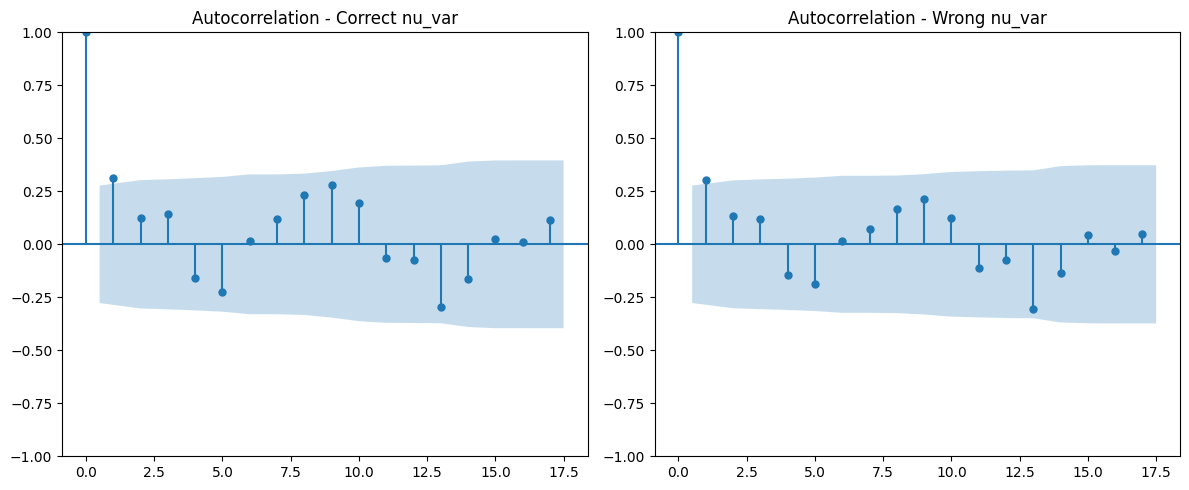

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

Correct nu_var: 2.4973015778172015e-05
wrong nu_var: 8.92873784919806e-06
--------------------
Number of p_vals < 0.05 for correct nu_var: 1
Number of p_vals < 0.05 for wrong nu_var: 1


In [50]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


a = 3
b = 2
c = 0.5
gamma = 2

nu_var = b/(1 - np.abs(c)**gamma)
wrong_nu_var = 4

# set_up
N = 50
p_vals = []
kpss_pvals = []
p_vals_wrong_nu_var = []
kpss_pvals_wrong_nu_var = []

# iterating to remove randomness effect
for i in tqdm(range(1)):
    # Geneterating data
    xx = np.zeros(N)
    xx_wrong_nu_var = np.zeros(N)
    xx[0] = np.random.normal(loc=a, scale=np.sqrt(nu_var))
    xx_wrong_nu_var[0] = np.random.normal(loc=a, scale=np.sqrt(wrong_nu_var))
    for i in range(1, N):
        error = np.random.normal(loc=a, scale=np.sqrt(b))
        xx[i] = -a + c * xx[i-1] + error
        xx_wrong_nu_var[i] = -a + c * xx_wrong_nu_var[i-1] + error  # np.random.normal(loc=a, scale=np.sqrt(wrong_nu_var))

    # testing stationarity
    p_vals.append(test_stationarity(xx, alpha=0.05, verbose=False))
    p_vals_wrong_nu_var.append(test_stationarity(xx_wrong_nu_var, alpha=0.05, verbose=False))
    # kpss_pvals.append(kpss_test(xx))
    # kpss_pvals_wrong_nu_var.append(kpss_test(xx_wrong_nu_var))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plot_acf(xx, ax=plt.gca(), title='Autocorrelation - Correct nu_var')
    plt.subplot(1, 2, 2)
    plot_acf(xx_wrong_nu_var, ax=plt.gca(), title='Autocorrelation - Wrong nu_var')
    plt.tight_layout()
    plt.show()


print("Correct nu_var:", np.mean(p_vals))
print("wrong nu_var:", np.mean(p_vals_wrong_nu_var))
print("--------------------")
print("Number of p_vals < 0.05 for correct nu_var:", np.sum(np.array(p_vals) < 0.05))
print("Number of p_vals < 0.05 for wrong nu_var:", np.sum(np.array(p_vals_wrong_nu_var) < 0.05))
# print("--------------------")
# print("KPSS Correct nu_var:", np.mean(kpss_pvals))
# print("KPSS wrong nu_var:", np.mean(kpss_pvals_wrong_nu_var))
# print("--------------------")
# print("Number of kpss_pvals < 0.05 for correct nu_var:", np.sum(np.array(kpss_pvals) < 0.05))
# print("Number of kpss_pvals < 0.05 for wrong nu_var:", np.sum(np.array(kpss_pvals_wrong_nu_var) < 0.05))


In [20]:
kpss_test(xx)
kpss_test(xx_wrong_nu_var)

Results of KPSS Test:
Test Statistic           0.170807
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of KPSS Test:
Test Statistic           0.656505
p-value                  0.017500
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_111828/395744607.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [31]:
# Generate AR(p) data
n_obs = 100
# Must be stationary
phis = np.array([0.5, 0.25])
n_lags = len(phis)
sigma = 3

data_obs = generate_ar_data(n_obs, phis, sigma=sigma)
resampled_data = resample_arp(data_obs, n_resamples=100, error_var=3, p=3)

ValueError: shapes (3,) and (1,) not aligned: 3 (dim 0) != 1 (dim 0)

In [27]:
test_stationarity(resampled_data)

MissingDataError: exog contains inf or nans